In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from misc_funcs import get_samples, indexes
from dataset_specifications.dataset import LabelledData
from networks import NoiseInjection, FeedForward, DoubleInputNetwork
from cgan_versions import PearsonCGAN, RKLCGAN, KLCGAN, WCGAN
from cgan import CGAN
import seaborn as sns
import pandas as pd
import evaluation as eval
import scipy.stats as ss
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler


plt.rcParams.update({'font.size': 13})
plt.rc("axes", labelsize=18)
plt.rc("axes", titlesize=21)
plt.rc("legend", fontsize=18)

In [2]:
# Gaussian mixtures
def mu1(x):
    return x+1 
def mu2(x):
    # return 2*x+1
    return 2*x+2.5
def mu3(x):
    return 4*x+5
def mu4(x):
    return 1.8*x+10
def std1(x): 
    return 0.2
def std2(x):
    # return np.sqrt(x+1.5)
    return 0.2+0.3*x
def std3(x):
    return 0.1+0.7*x
def std4(x):
    return 0.8-0.5*x
def pdf_func(x, x_supp, mixture_params, mixture_weights):
    y_pdf = np.zeros_like(x_supp)
    for (l, s), w in zip(mixture_params, mixture_weights):
        y_pdf += ss.norm.pdf(x_supp, loc=l(x), scale=s(x))*w
    return y_pdf

def sample_ys(x_samples,
            mixture_params,
            mixture_idx,
            n):
    assert len(x_samples) == n, 'Sizes are not the same'
    # Sampling from GM
    y_samples = []
    for idx, i in enumerate(mixture_idx):
        mean = mixture_params[i,0]
        std = mixture_params[i,1]
        sample = ss.norm.rvs(loc=mean(x_samples[idx]), scale=std(x_samples[idx]))
        y_samples.append(sample)
    return np.array(y_samples)

def sample(xs = np.random.uniform(low=0, high=1, size=5000),
           mixture_weights = np.array([0.1,0.4,0.2,0.3]),
           mixture_params = np.array([[mu1,std1],[mu2, std2],[mu3,std3],[mu4,std4]]),
           ):

    mixture_n_comp = mixture_params.shape[0]
    n = len(xs)
    assert mixture_n_comp == len(mixture_weights), 'Not the same size'
    mixture_idx = np.random.choice(mixture_n_comp, size = n, p = mixture_weights)

    ys = sample_ys(xs, mixture_params, mixture_idx, n)
    # print(ys.shape)
    # print(xs.shape)
    return np.stack((xs, ys), axis=1)

In [3]:
params = np.array([[mu1,std1],[mu2, std2],[mu3,std3],[mu4,std4]])#
weights = np.array([0.1,0.4,0.2,0.3])

Sampling for dataset creation; skip if not needed

In [42]:
num_samples = 2000
x_samples = np.random.uniform(low=0, high=1, size=num_samples)
combined = sample(x_samples, mixture_weights= weights, mixture_params = params)

In [49]:
# Make sure that GM from above corresponds to data imported below
combined_train, combined_validation = model_selection.train_test_split(combined, test_size=0.5, random_state=43)

scaler = StandardScaler()
train_set_scaled = scaler.fit_transform(combined_train)
# Scale test data based on training data
val_set_scaled = scaler.transform(combined_validation)

tmp = np.random.choice(len(combined_validation),50, replace=False)
x_samples_test_repeated = np.repeat(combined_validation[tmp,:-1], repeats=200, axis = 0)
x_samples_test_repeated = x_samples_test_repeated.reshape((len(x_samples_test_repeated,)))
combined_test = sample(x_samples_test_repeated)
test_set_scaled = scaler.transform(combined_test)

Make sure imported and exported data are from same GM

In [50]:
#export data
DATASET_PATH = 'datasets'
DATASET_NAME = 'GM'

# preprocessing folder
raw_dataset_path = os.path.join(DATASET_PATH,DATASET_NAME,'raw_data')

if not os.path.exists(raw_dataset_path):
    os.makedirs(raw_dataset_path)
# raw data
np.savetxt("./{}/train.csv".format(raw_dataset_path), combined_train,delimiter=",")
np.savetxt("./{}/val.csv".format(raw_dataset_path), combined_validation,delimiter=",")
np.savetxt("./{}/test.csv".format(raw_dataset_path), combined_test,delimiter=",")

# scaled data
np.savetxt("./{}/{}/train.csv".format(DATASET_PATH,DATASET_NAME), train_set_scaled,delimiter=",")
np.savetxt("./{}/{}/val.csv".format(DATASET_PATH,DATASET_NAME), val_set_scaled,delimiter=",")
np.savetxt("./{}/{}/test.csv".format(DATASET_PATH,DATASET_NAME), test_set_scaled,delimiter=",")

In [52]:
tmp = np.random.choice(len(combined_validation),50, replace=False)
x_samples_train_repeated = np.repeat(combined_train[tmp,:-1], repeats=200, axis = 0)
x_samples_train_repeated = x_samples_train_repeated.reshape((len(x_samples_train_repeated,)))
combined_train_repeated = sample(x_samples_train_repeated)
train_set_repeated_scaled = scaler.transform(combined_train_repeated)
np.savetxt("./{}/train_repeated.csv".format(raw_dataset_path), combined_train_repeated,delimiter=",")
np.savetxt("./{}/{}/train_repeated.csv".format(DATASET_PATH,DATASET_NAME), train_set_repeated_scaled,delimiter=",")


Model definition starts here

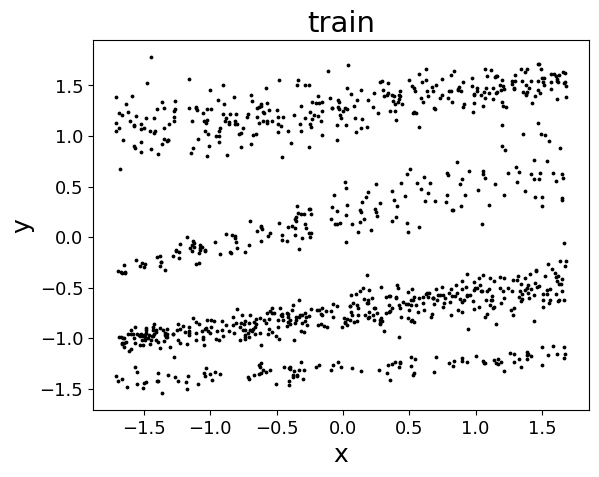

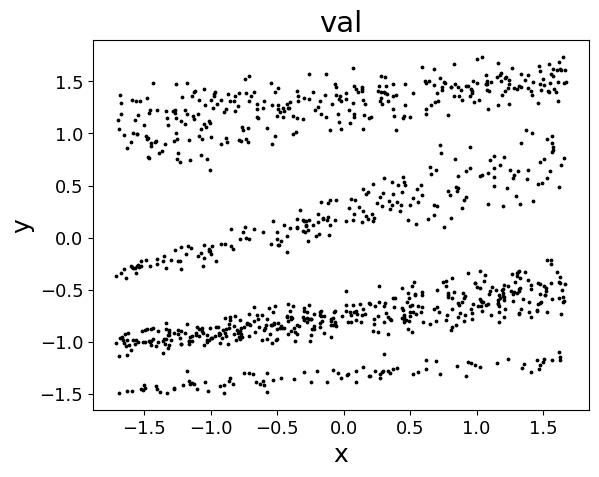

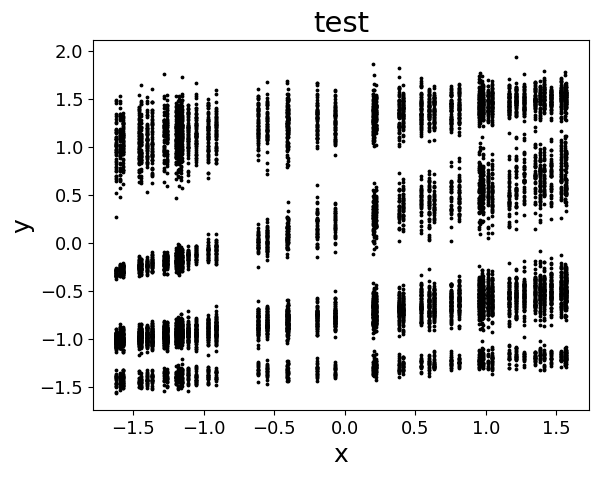

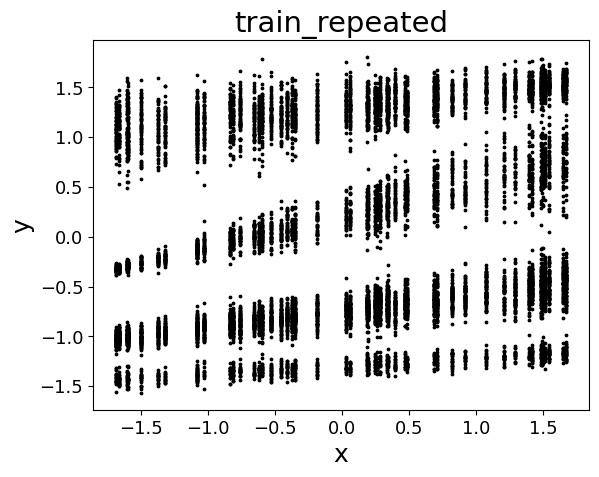

In [3]:
#import data
DATASET_PATH = 'datasets'
DATASET_NAME = 'GM'
dataset_dir = os.path.join(DATASET_PATH,DATASET_NAME)
assert os.path.exists(dataset_dir),("dataset folder {} does not exist".format(dataset_dir))

splits = {}
#CHANGE DIMENSIONS OF DATA ACCORDINGLY
X_DIM = 1
Y_DIM = 1
scatter_plot = 1

for split in ("train","val","test",'train_repeated'):
    data_path = os.path.join(dataset_dir,"{}.csv".format(split))
    assert os.path.exists(data_path),"data file {} does not exist".format(data_path)
    
    data = np.genfromtxt(data_path,delimiter=",")
    if scatter_plot:
        plt.figure
        plt.scatter(data[:,:1],data[:,1:], c='k', s=3)
        plt.xlabel("x")
        plt.ylabel('y')
        plt.title(split)
        plt.show()
    torch_data = torch.tensor(data, device="cpu").float()
    splits[split] = LabelledData(x=torch_data[:,:X_DIM],y=torch_data[:,X_DIM:])

train_data = splits["train"]
val_data = splits['val']
test_data = splits['test']
train_data_repeated = splits['train_repeated']

In [36]:
# path for saving parameters of model
PARAM_PATH = './param_best'
FILE_NAME = 'GM_CGAN_nd_5'

# For saving plots
PLOT_PATH = './plots'
PLT_DATASET_NAME = 'GM'


constants = {
    "dataset_path": DATASET_PATH,
    "dataset_name": DATASET_NAME,
    # "channel_name": CHANNEL_NAME,
    "plot_path": PLOT_PATH,
    "plt_dataset_name": PLT_DATASET_NAME,
    "param_path": PARAM_PATH,
    "file_name": FILE_NAME,
    "x_dim": X_DIM,
    "y_dim": Y_DIM
}

In [34]:
def val_func(model, epoch):
    return eval.evaluate_model(model, data_val = val_data, data_train = train_data, data_test = test_data, 
                               data_train_repeated = train_data_repeated, epoch = epoch)

Epoch 19, true	ll: -1.5599	mae: 0.96176	Wasserstein-1 dist: 0.83748	Wasserstein-2 dist: 0.93034
Epoch 39, true	ll: -1.5133	mae: 0.89842	Wasserstein-1 dist: 0.58674	Wasserstein-2 dist: 0.71813
Epoch 59, true	ll: -1.8568	mae: 1.3566	Wasserstein-1 dist: 1.9232	Wasserstein-2 dist: 2.4293
Epoch 79, true	ll: -1.4139	mae: 0.87466	Wasserstein-1 dist: 0.38952	Wasserstein-2 dist: 0.53992
Epoch 99, true	ll: -1.3025	mae: 0.87606	Wasserstein-1 dist: 0.26941	Wasserstein-2 dist: 0.37295
Epoch 119, true	ll: -1.204	mae: 0.86696	Wasserstein-1 dist: 0.14292	Wasserstein-2 dist: 0.27812
Epoch 139, true	ll: -1.2309	mae: 0.8739	Wasserstein-1 dist: 0.14952	Wasserstein-2 dist: 0.21106
Epoch 159, true	ll: -1.2477	mae: 0.86974	Wasserstein-1 dist: 0.15934	Wasserstein-2 dist: 0.20436
Epoch 179, true	ll: -1.1998	mae: 0.86636	Wasserstein-1 dist: 0.14085	Wasserstein-2 dist: 0.19258
Epoch 199, true	ll: -1.184	mae: 0.87755	Wasserstein-1 dist: 0.13718	Wasserstein-2 dist: 0.18692
Epoch 219, true	ll: -1.1642	mae: 0.86907	

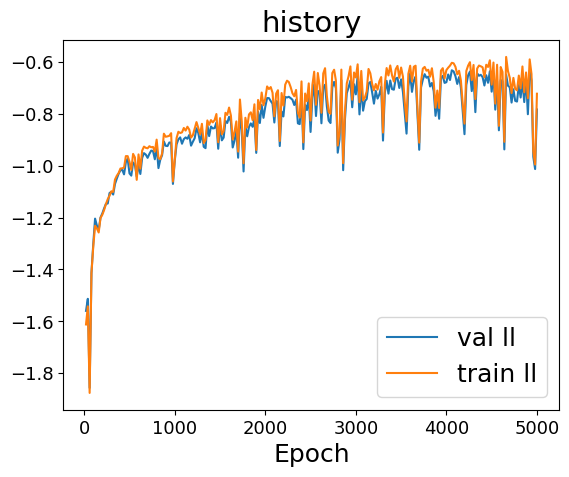

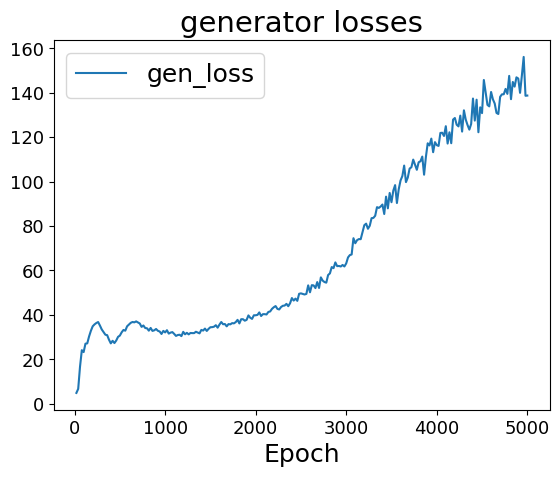

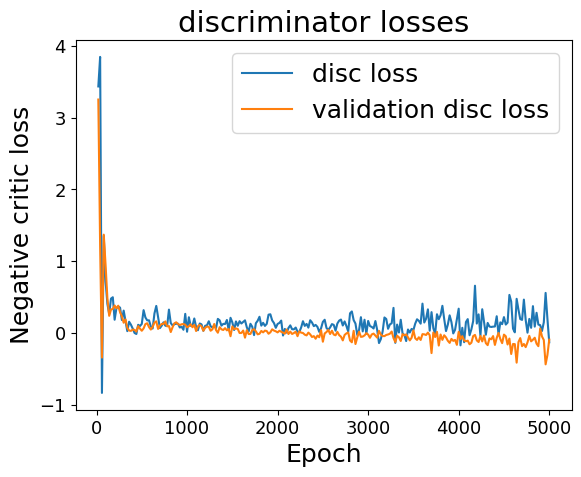

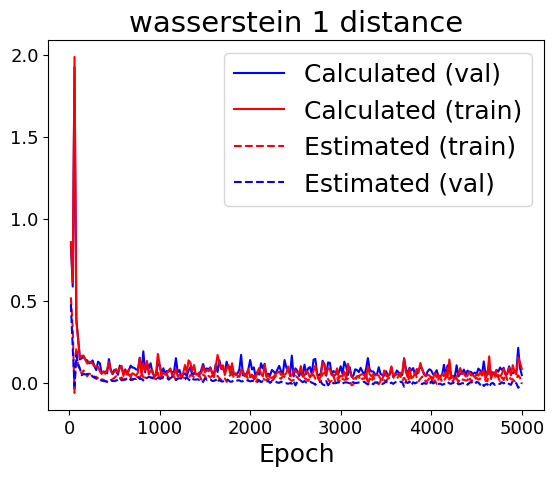

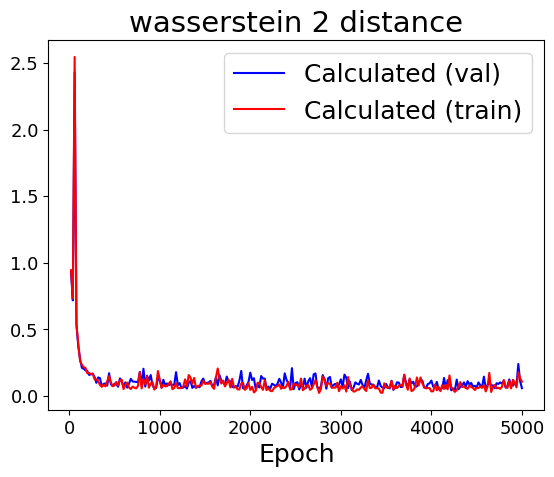

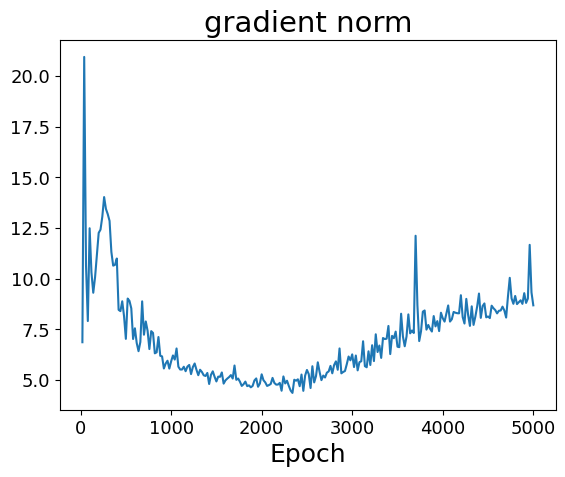

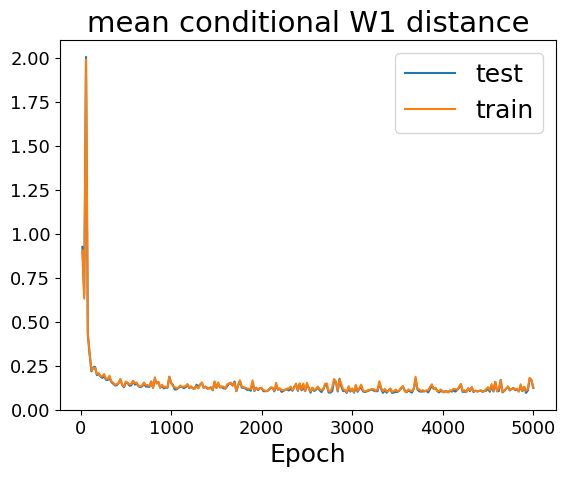

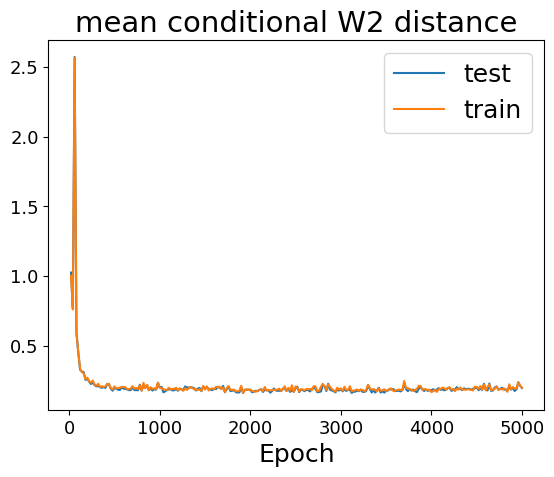

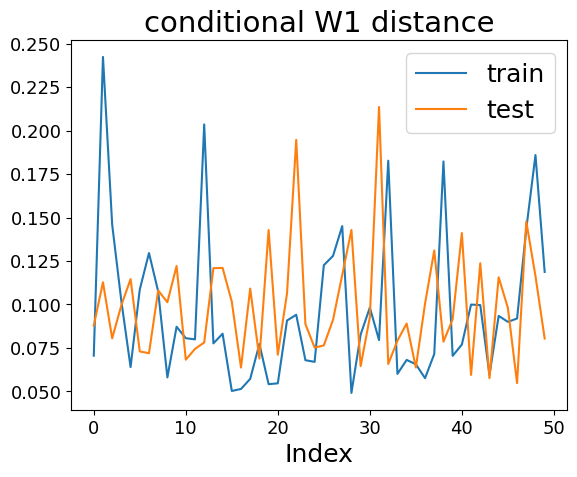

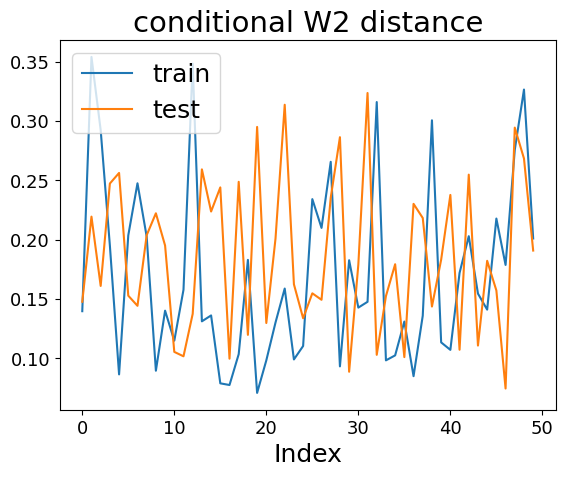

In [27]:
#create nn spec for discriminator and generator
config = {
    "noise_dim": 5,
    "epochs": 5000,
    "batch_size": 200,
    "gen_lr": 4e-4,
    "disc_lr": 2e-4,
    "val_interval": 20,
    "eval_batch_size": 1000,
    "eval_samples": 200,
    "kernel_scales": 50,
    "kernel_scale_min": 0.001,
    "kernel_scale_max": 0.7,
    "pdf_index":0,
    "scatter": 1,
    "kde_batch_size": 15,
    "n_critic": 5,
    "lambda_gp": 2e-2,
    'one-sided': True
}
nn_spec = {'gen_spec' : {
    "other_dim": config["noise_dim"],#noise dimensions
    "cond_dim": X_DIM,#conditioning data
    "nodes_per_layer": [64,64,64,64],
    "output_dim": Y_DIM,#fake data dimensions
    "activation": nn.ReLU(),
    "type": FeedForward,
    "dropout":None,
    "activation_final": 0,
    "spectral_normalisation": None,
    "batch_norm": None,
},
'disc_spec': {
    "other_dim": Y_DIM,#actual data dimensions
    "cond_dim": X_DIM,    
    "nodes_per_layer": [64,64,64,64],
    # "cond_layers": [64],
    # "other_layers":[64],
    "output_dim": 1,#output logit
    "activation":nn.ReLU(),
    "type": FeedForward,
    "dropout": None,
    "activation_final": 0,
    "batch_norm": None,
    "spectral_normalisation": None
}
}

cgan_model = WCGAN(config, nn_spec, constants)
cgan_model.train(train_data, val_data, test_data, val_func)

In [67]:
# config = {
#     "noise_dim": 30,
#     "epochs": 50000,
#     "batch_size": 200,
#     "gen_lr": 1e-4,
#     "disc_lr": 1e-4,
#     "val_interval": 100,
#     "eval_batch_size": 1000,
#     "eval_samples": 200,
#     "kernel_scales": 50,
#     "kernel_scale_min": 0.001,
#     "kernel_scale_max": 0.5,
#     "pdf_index":0,
#     "scatter": 1,
#     "kde_batch_size": 10,
#     "n_critic": 10,
#     "lambda_gp": 1e-2,
#     'one-sided': False
# }


# nn_spec = {'gen_spec' : {
#     "other_dim": config["noise_dim"],#noise dimensions
#     "cond_dim": X_DIM,#conditioning data
#     "nodes_per_layer": [16,16,16,16],
#     "output_dim": Y_DIM,#fake data dimensions
#     "activation": nn.ReLU(),
#     "type": FeedForward,
#     "dropout":None,
#     "activation_final": 0,
#     "spectral_normalisation": None
# },
# 'disc_spec': {
#     "other_dim": Y_DIM,#actual data dimensions
#     "cond_dim": X_DIM,
#     "nodes_per_layer": [128,128,128,128],
#     "output_dim": 1,#output logit
#     "activation": nn.ReLU(),
#     "type": FeedForward,
#     "dropout":None,
#     "activation_final": 0,
#     "spectral_normalisation": None
# }
# }
# cgan_model = WCGAN(config, nn_spec, constants)
# cgan_model.train(train_data, val_data, val_func)

Epoch 19, true	ll: -1.6579	mae: 1.1203	Wasserstein-1 dist: 0.76308	Wasserstein-2 dist: 0.83581
Epoch 39, true	ll: -1.5267	mae: 0.89926	Wasserstein-1 dist: 0.5571	Wasserstein-2 dist: 0.63468
Epoch 59, true	ll: -1.3209	mae: 0.87893	Wasserstein-1 dist: 0.21616	Wasserstein-2 dist: 0.41896
Epoch 79, true	ll: -1.1663	mae: 0.86789	Wasserstein-1 dist: 0.12173	Wasserstein-2 dist: 0.23554
Epoch 99, true	ll: -1.1627	mae: 0.88057	Wasserstein-1 dist: 0.1334	Wasserstein-2 dist: 0.19415
Epoch 119, true	ll: -0.97401	mae: 0.88437	Wasserstein-1 dist: 0.13032	Wasserstein-2 dist: 0.18389
Epoch 139, true	ll: -0.98917	mae: 0.87514	Wasserstein-1 dist: 0.092692	Wasserstein-2 dist: 0.13352
Epoch 159, true	ll: -0.91886	mae: 0.88559	Wasserstein-1 dist: 0.10929	Wasserstein-2 dist: 0.15895
Epoch 179, true	ll: -0.90152	mae: 0.88814	Wasserstein-1 dist: 0.12251	Wasserstein-2 dist: 0.1848
Epoch 199, true	ll: -0.8857	mae: 0.88307	Wasserstein-1 dist: 0.091015	Wasserstein-2 dist: 0.13955
Epoch 219, true	ll: -0.88052	mae:

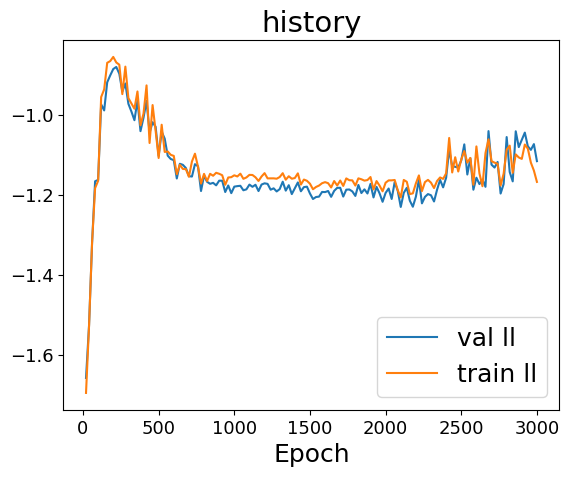

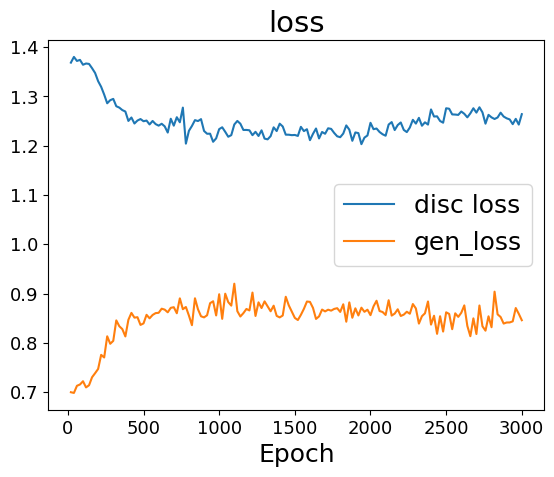

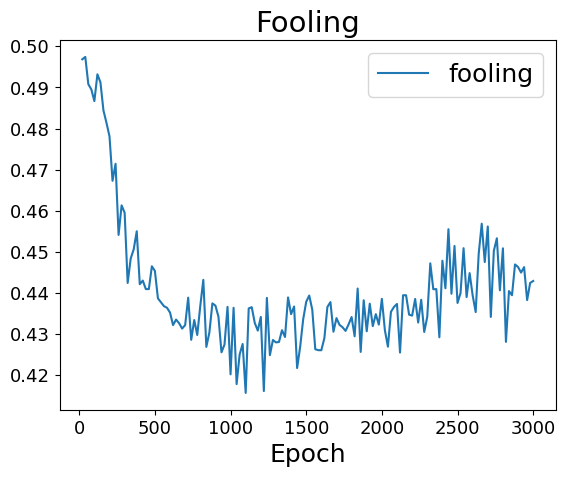

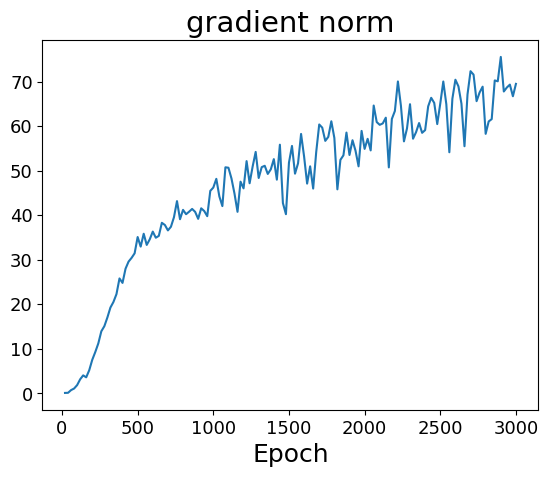

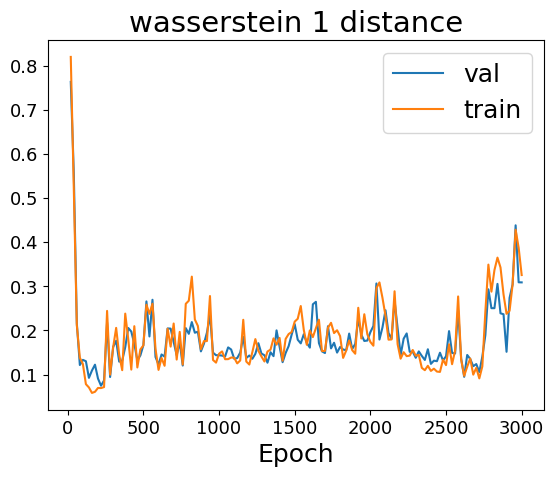

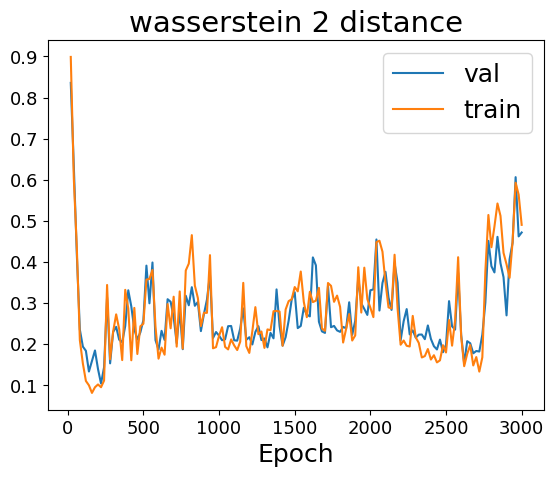

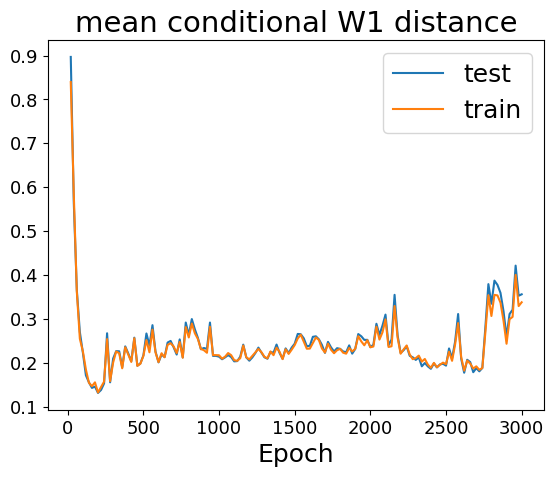

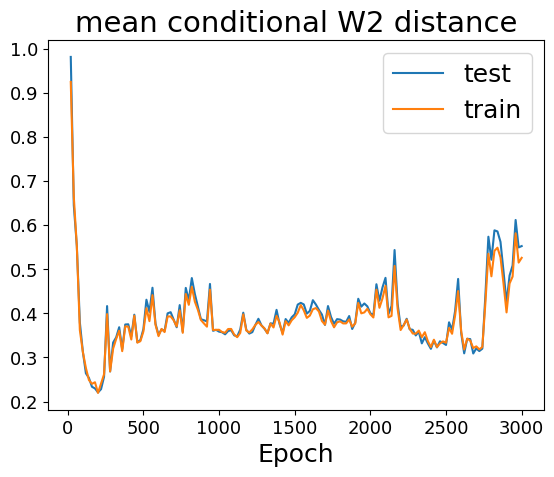

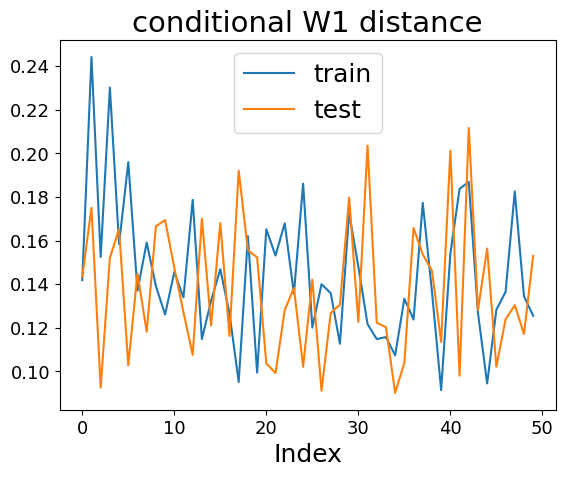

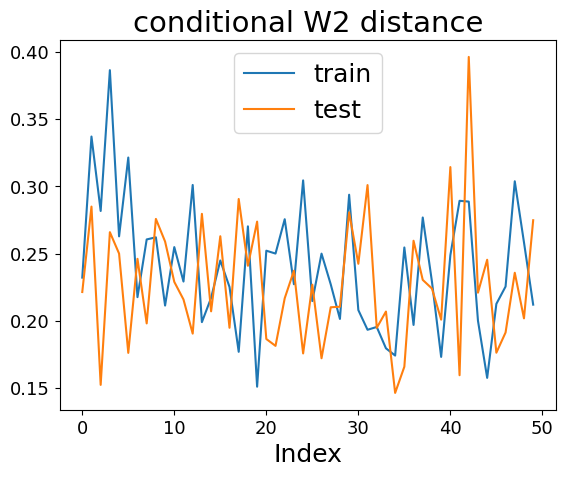

In [37]:
#create nn spec for discriminator and generator
config = {
    "noise_dim": 5,
    "epochs": 3000,
    "batch_size": 200,
    "gen_lr": 1e-4,
    "disc_lr": 1e-4,
    "val_interval": 20,
    "eval_batch_size": 1000,
    "eval_samples": 200,
    "kernel_scales": 50,
    "kernel_scale_min": 0.001,
    "kernel_scale_max": 0.7,
    "pdf_index":0,
    "scatter": 1,
    "kde_batch_size": 15,
}
nn_spec = {'gen_spec' : {
    "other_dim": config["noise_dim"],#noise dimensions
    "cond_dim": X_DIM,#conditioning data
    "nodes_per_layer": [64, 64, 64, 64, 64, 64],
    "output_dim": Y_DIM,#fake data dimensions
    "activation": nn.ReLU(),
    "type": NoiseInjection,
    "dropout":None,
    "activation_final": 0,
    "spectral_normalisation": None
},
'disc_spec': {
    "other_dim": Y_DIM,#actual data dimensions
    "cond_dim": X_DIM,
    "nodes_per_layer": [64, 64, 64, 64, 64, 64],
    "cond_layers": [64,64],
    "other_layers":[64,64],
    "output_dim": 1,#output logit
    "activation": nn.ReLU(),
    "type": DoubleInputNetwork,
    "dropout":None,
    "activation_final": 0,
    "spectral_normalisation": None
}
}
cgan_model = CGAN(config, nn_spec, constants)
cgan_model.train(train_data, val_data, test_data, val_func)

In [14]:
best_save_path = os.path.join(cgan_model.param_dir,
                            "epoch_best.pt") # Path to save best params to
checkpoint = torch.load(best_save_path, map_location=cgan_model.device)
cgan_model.critic.load_state_dict(checkpoint["disc"])
if "gen" in checkpoint:
    cgan_model.gen.load_state_dict(checkpoint["gen"])

In [20]:
# import raw data
raw_dataset_path = os.path.join(DATASET_PATH,DATASET_NAME,'raw_data')
raw_train = np.genfromtxt(os.path.join(raw_dataset_path,'train.csv'),delimiter=",")

Text(0.5, 1.0, 'x=1')

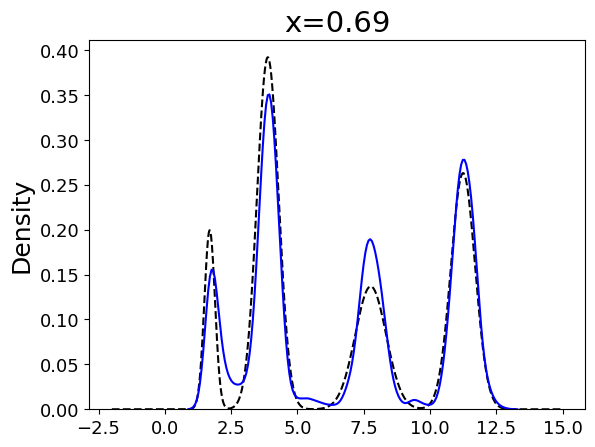

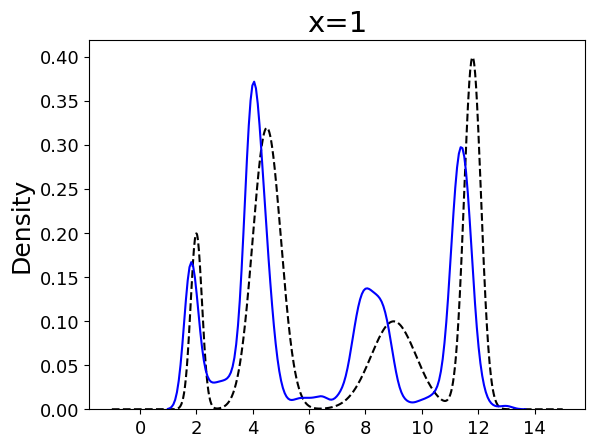

In [25]:
xs = 0.69
xs2 = 1
x_pdf = np.linspace(-2,15,1000)#support of pdf
x_pdf2 = np.linspace(-1,15,1000)#support of pdf

y_pdf = pdf_func(xs,x_pdf,params, weights)
y_pdf2 = pdf_func(xs2,x_pdf2,params, weights)

y_train_mean = raw_train[:,1].mean()
y_train_std = np.std(raw_train[:,1], axis = 0)

# # Sample from model
y_gen = get_samples(cgan_model,xs).numpy()
y_gen = y_gen*y_train_std+y_train_mean

plt.figure()
plt.plot(x_pdf, y_pdf, color ='k', linestyle='--',label='x={}'.format(xs))
sns.kdeplot(y_gen.squeeze(),color='b', bw_adjust=0.25)
plt.title('x={}'.format(xs))
plt.figure()
plt.plot(x_pdf2, y_pdf2, color ='k', linestyle='--')
y_gen2 = get_samples(cgan_model,xs2)
y_gen2 = y_gen2*y_train_std+y_train_mean
sns.kdeplot(y_gen2.squeeze(),color='b', legend=True, bw_adjust=0.25)
plt.title('x={}'.format(xs2))

In [26]:
# extract x-values of real (empirical) pdf
x_values_scale, x_values_index = np.unique(test_data.x, axis = 0, return_index=True)
x_values = np.unique(test_data.x, axis = 0)
num_samples_gen = 300 # number of samples per pdf location
sort =np.argsort(x_values_index)
x_values_scale = x_values_scale[sort]
x_values_index = x_values_index[sort]
x_values = x_values[sort]

In [27]:
# preprocessing folder
samplepdf_imgs_path = os.path.join(PLOT_PATH,PLT_DATASET_NAME,FILE_NAME,'Sample_PDF')

if not os.path.exists(samplepdf_imgs_path):
    os.makedirs(samplepdf_imgs_path)
else:
    for f in os.listdir(samplepdf_imgs_path):
        os.remove(os.path.join(samplepdf_imgs_path,f))


In [28]:
# plot generated pdf against real (empirical) pdf
assert os.path.exists(samplepdf_imgs_path),("dataset folder {} does not exist".format(samplepdf_imgs_path))
gen_samples = np.zeros((num_samples_gen,len(x_values_scale)))
real_samples = np.zeros((num_samples_real,len(x_values_scale)))

print('Plotting samples for all x-locations...')
for i, (idx,values_scaled) in enumerate(zip(x_values_index, x_values_scale)):
    gen_samples[:,i] = get_samples(cgan_model, values_scaled, num_samples_gen).squeeze(1)
    plt.figure()
    sns.kdeplot(gen_samples[:,i], color ='b',label='Gen', bw_adjust=0.25)
    tmp = indexes(test_data.x[idx], test_data.x)
    real_samples[:,i] = test_data.y[tmp].squeeze()
    sns.kdeplot(real_samples[:,i], color='k', linestyle='--', label='Empirical', bw_adjust=0.25)
    plt.title('x={}'.format(x_values[i]), fontsize=10)
    plt.tight_layout()
    plt.legend()
    plt.savefig('{}/idx_{}.png'.format(samplepdf_imgs_path, i))
    plt.close()
print('Plotting samples for all x-locations finished')


Plotting samples for all x-locations...
Plotting samples for all x-locations finished


In [17]:
tmp = gen_samples.reshape(-1,1, order='F')


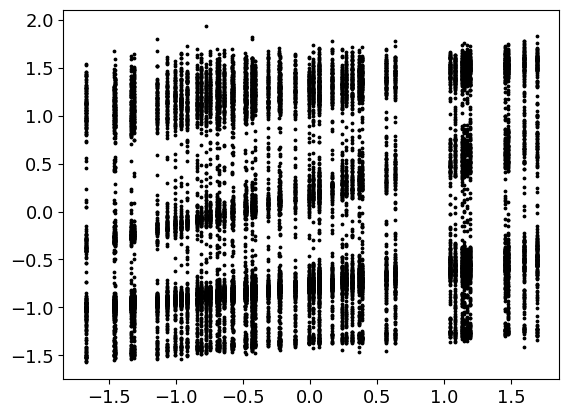

In [18]:
plt.scatter(test_data.x,tmp, s=3, color = 'k')

In [ ]:
critic_weights = []
for name, param in cgan_model.critic.named_parameters():
    if 'weight' in name:
        critic_weights.append(param.detach().numpy())
for i, w in enumerate(critic_weights):
    # if i == 0:
    #     tmp = np.array(w)
    # else:
    #     tmp = np.concatenate((tmp,w), a)
    w = w.reshape(-1,1)
    critic_weights[i] = w
    if i == 0:
        tmp = np.array(critic_weights[i])
    else:
        tmp = np.concatenate((tmp, critic_weights[i]))
plt.figure()
plt.hist(tmp, bins = 500)
max(tmp)
# plt.figure()
# plt.plot(wcgan_model.gradient_norm)
# plt.plot(wcgan_model.gradient_norm_val)

(array([-2500.,     0.,  2500.,  5000.,  7500., 10000., 12500., 15000.,
        17500., 20000., 22500.]),
 [Text(-2500.0, 0, '−2500'),
  Text(0.0, 0, '0'),
  Text(2500.0, 0, '2500'),
  Text(5000.0, 0, '5000'),
  Text(7500.0, 0, '7500'),
  Text(10000.0, 0, '10000'),
  Text(12500.0, 0, '12500'),
  Text(15000.0, 0, '15000'),
  Text(17500.0, 0, '17500'),
  Text(20000.0, 0, '20000'),
  Text(22500.0, 0, '22500')])

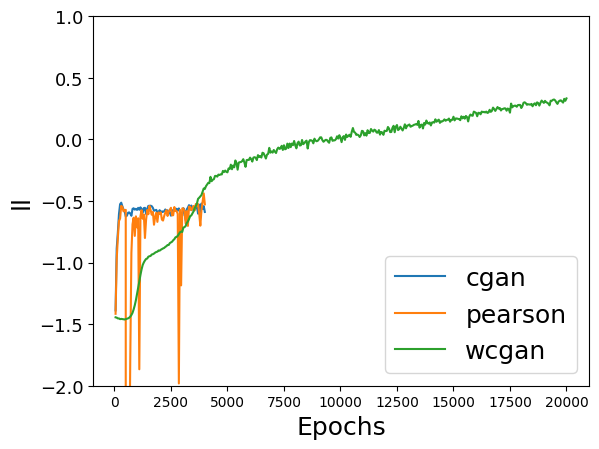

In [9]:
path = os.path.join('postprocess','aero','ll.csv')
tmp = pd.read_csv(path, delimiter=',')
plt.figure()
for model in ('cgan', "pearson"):
    plt.plot(tmp['epoch'],tmp[model], label=model)
plt.plot(tmp['epoch.1'],tmp['wcgan'], label = 'wcgan')
plt.legend()
plt.ylabel("ll")
plt.xlabel('Epochs')
plt.ylim([-2,1])
plt.xticks(fontsize=10)

# plt.figure()
# plt.plot(tmp[:,0],tmp)